<a href="https://colab.research.google.com/github/cakrabudiman/Logistic-Mixed-effect-Model-for-Final-Project/blob/main/LMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Model LMM(Logistic Mixed-effect Model**)

Load dan Persiapan Dataset

In [ ]:
!pip install pandas statsmodels openpyxl

import pandas as pd
file_path = "Evaluasi soal Kalkulus_fix.xlsx"
xls = pd.ExcelFile(file_path)
limit_df = xls.parse('limit')
turunan_df = xls.parse('turunan')
integral_df = xls.parse('integral')

for df_temp, jenis in zip([limit_df, turunan_df, integral_df], ['limit', 'turunan', 'integral']):
    df_temp['JenisSoal'] = jenis

df = pd.concat([limit_df, turunan_df, integral_df], ignore_index=True)
df.rename(columns={"Correcness": "Correctness", "Tingkat kesulitan": "Tingkat_kesulitan"}, inplace=True)

df['Teknik'] = df['Teknik'].astype('category')
df['JenisSoal'] = df['JenisSoal'].astype('category')
df['Tingkat_kesulitan'] = df['Tingkat_kesulitan'].astype('category')
df['No Soal'] = df['No Soal'].astype('category')

In [ ]:
average_by_jenis_soal = df.groupby('JenisSoal', observed=True)[['Clarity', 'Correctness', 'Strategy', 'Representation']].mean().round(2)
average_by_tingkat_kesulitan = df.groupby('Tingkat_kesulitan', observed=True)[['Clarity', 'Correctness', 'Strategy', 'Representation']].mean().round(2)

# Hitung rata-rata per Teknik Prompting (Fix: Menambahkan perhitungan average_scores)
average_scores = df.groupby('Teknik', observed=True)[['Clarity', 'Correctness', 'Strategy', 'Representation']].mean().round(2)

# Gabungkan semua hasil ke dalam satu dictionary untuk ditampilkan
all_averages = {
    "Rata-rata per Teknik Prompting": average_scores,
    "Rata-rata per Jenis Soal": average_by_jenis_soal,
    "Rata-rata per Tingkat Kesulitan": average_by_tingkat_kesulitan
}

# Tampilkan semua rata-rata
display(all_averages)

{'Rata-rata per Teknik Prompting':                   Clarity  Correctness  Strategy  Representation
 Teknik                                                          
 Chain-of-Thought     0.93         0.97      0.93            1.00
 Few-Shot             0.71         0.96      0.84            0.99
 Zero-Shot            0.86         0.96      0.83            1.00,
 'Rata-rata per Jenis Soal':            Clarity  Correctness  Strategy  Representation
 JenisSoal                                                
 integral      0.99         0.99      0.99            0.99
 limit         0.92         0.89      0.62            1.00
 turunan       0.59         1.00      1.00            1.00,
 'Rata-rata per Tingkat Kesulitan':                    Clarity  Correctness  Strategy  Representation
 Tingkat_kesulitan                                                
 mudah                 0.82         0.96      0.76            1.00
 sedang                0.91         0.96      0.89            0.99
 sulit  

Latih Model Logistic Mixed Effects (LMM)

In [ ]:
import statsmodels.formula.api as smf

results = {}
coef_data = []

for target in ['Clarity', 'Correctness', 'Strategy', 'Representation']:
    print(f"\n=== Model for {target} ===")
    try:
        df_target = df[df[target].notnull()].copy()
        df_target[target] = df_target[target].astype(int)

        model = smf.mixedlm(
            f"{target} ~ Teknik + JenisSoal + Tingkat_kesulitan",
            df_target,
            groups=df_target["No Soal"]
        )
        result = model.fit(reml=False, method="nm", maxiter=2000, full_output=True)
        results[target] = result
        print(result.summary())
    except Exception as e:
        print(f" Gagal memodelkan {target}: {e}")

    # Simpan data koefisien dan confidence interval
    params = result.params
    conf_int = result.conf_int()
    for var in params.index:
        if var == "Intercept":
            continue
        coef_data.append({
            "Kriteria": target,
            "Variabel": var,
            "Koefisien": params[var],
            "CI Lower": conf_int.loc[var][0],
            "CI Upper": conf_int.loc[var][1]
        })

coef_df = pd.DataFrame(coef_data)



=== Model for Clarity ===
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Clarity 
No. Observations:       270          Method:                  ML      
No. Groups:             10           Scale:                   0.0953  
Min. group size:        27           Log-Likelihood:          -66.9709
Max. group size:        27           Converged:               Yes     
Mean group size:        27.0                                          
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    1.078    0.051 21.284 0.000  0.979  1.177
Teknik[T.Few-Shot]          -0.222    0.046 -4.828 0.000 -0.312 -0.132
Teknik[T.Zero-Shot]         -0.078    0.046 -1.690 0.091 -0.168  0.012
JenisSoal[T.limit]          -0.067    0.046 -1.448 0.147 -0.157  0.

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Strategy
No. Observations:       270          Method:                  ML      
No. Groups:             10           Scale:                   0.0724  
Min. group size:        27           Log-Likelihood:          -28.6909
Max. group size:        27           Converged:               Yes     
Mean group size:        27.0                                          
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.937    0.043 21.626 0.000  0.852  1.022
Teknik[T.Few-Shot]          -0.089    0.040 -2.216 0.027 -0.168 -0.010
Teknik[T.Zero-Shot]         -0.100    0.040 -2.493 0.013 -0.179 -0.021
JenisSoal[T.limit]          -0.367    0.040 -9.140 0.000 -0.445 -0.288
JenisSoal[T.turunan]   

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Visualisasi Koefisien LMM

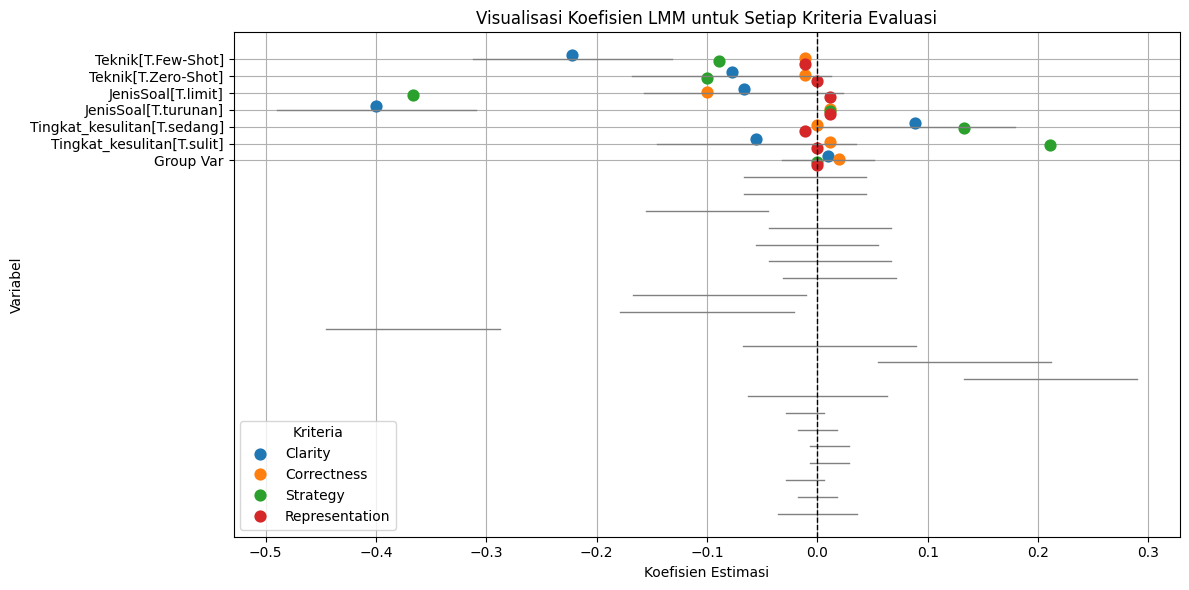

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.pointplot(data=coef_df, x="Koefisien", y="Variabel", hue="Kriteria", join=False, dodge=0.5, palette="tab10")

# Tambahkan garis Confidence Interval
for i, row in coef_df.iterrows():
    plt.plot([row["CI Lower"], row["CI Upper"]], [i, i], color="grey", linewidth=1)

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title("Visualisasi Koefisien LMM untuk Setiap Kriteria Evaluasi")
plt.xlabel("Koefisien Estimasi")
plt.ylabel("Variabel")
plt.tight_layout()
plt.grid(True)
plt.show()


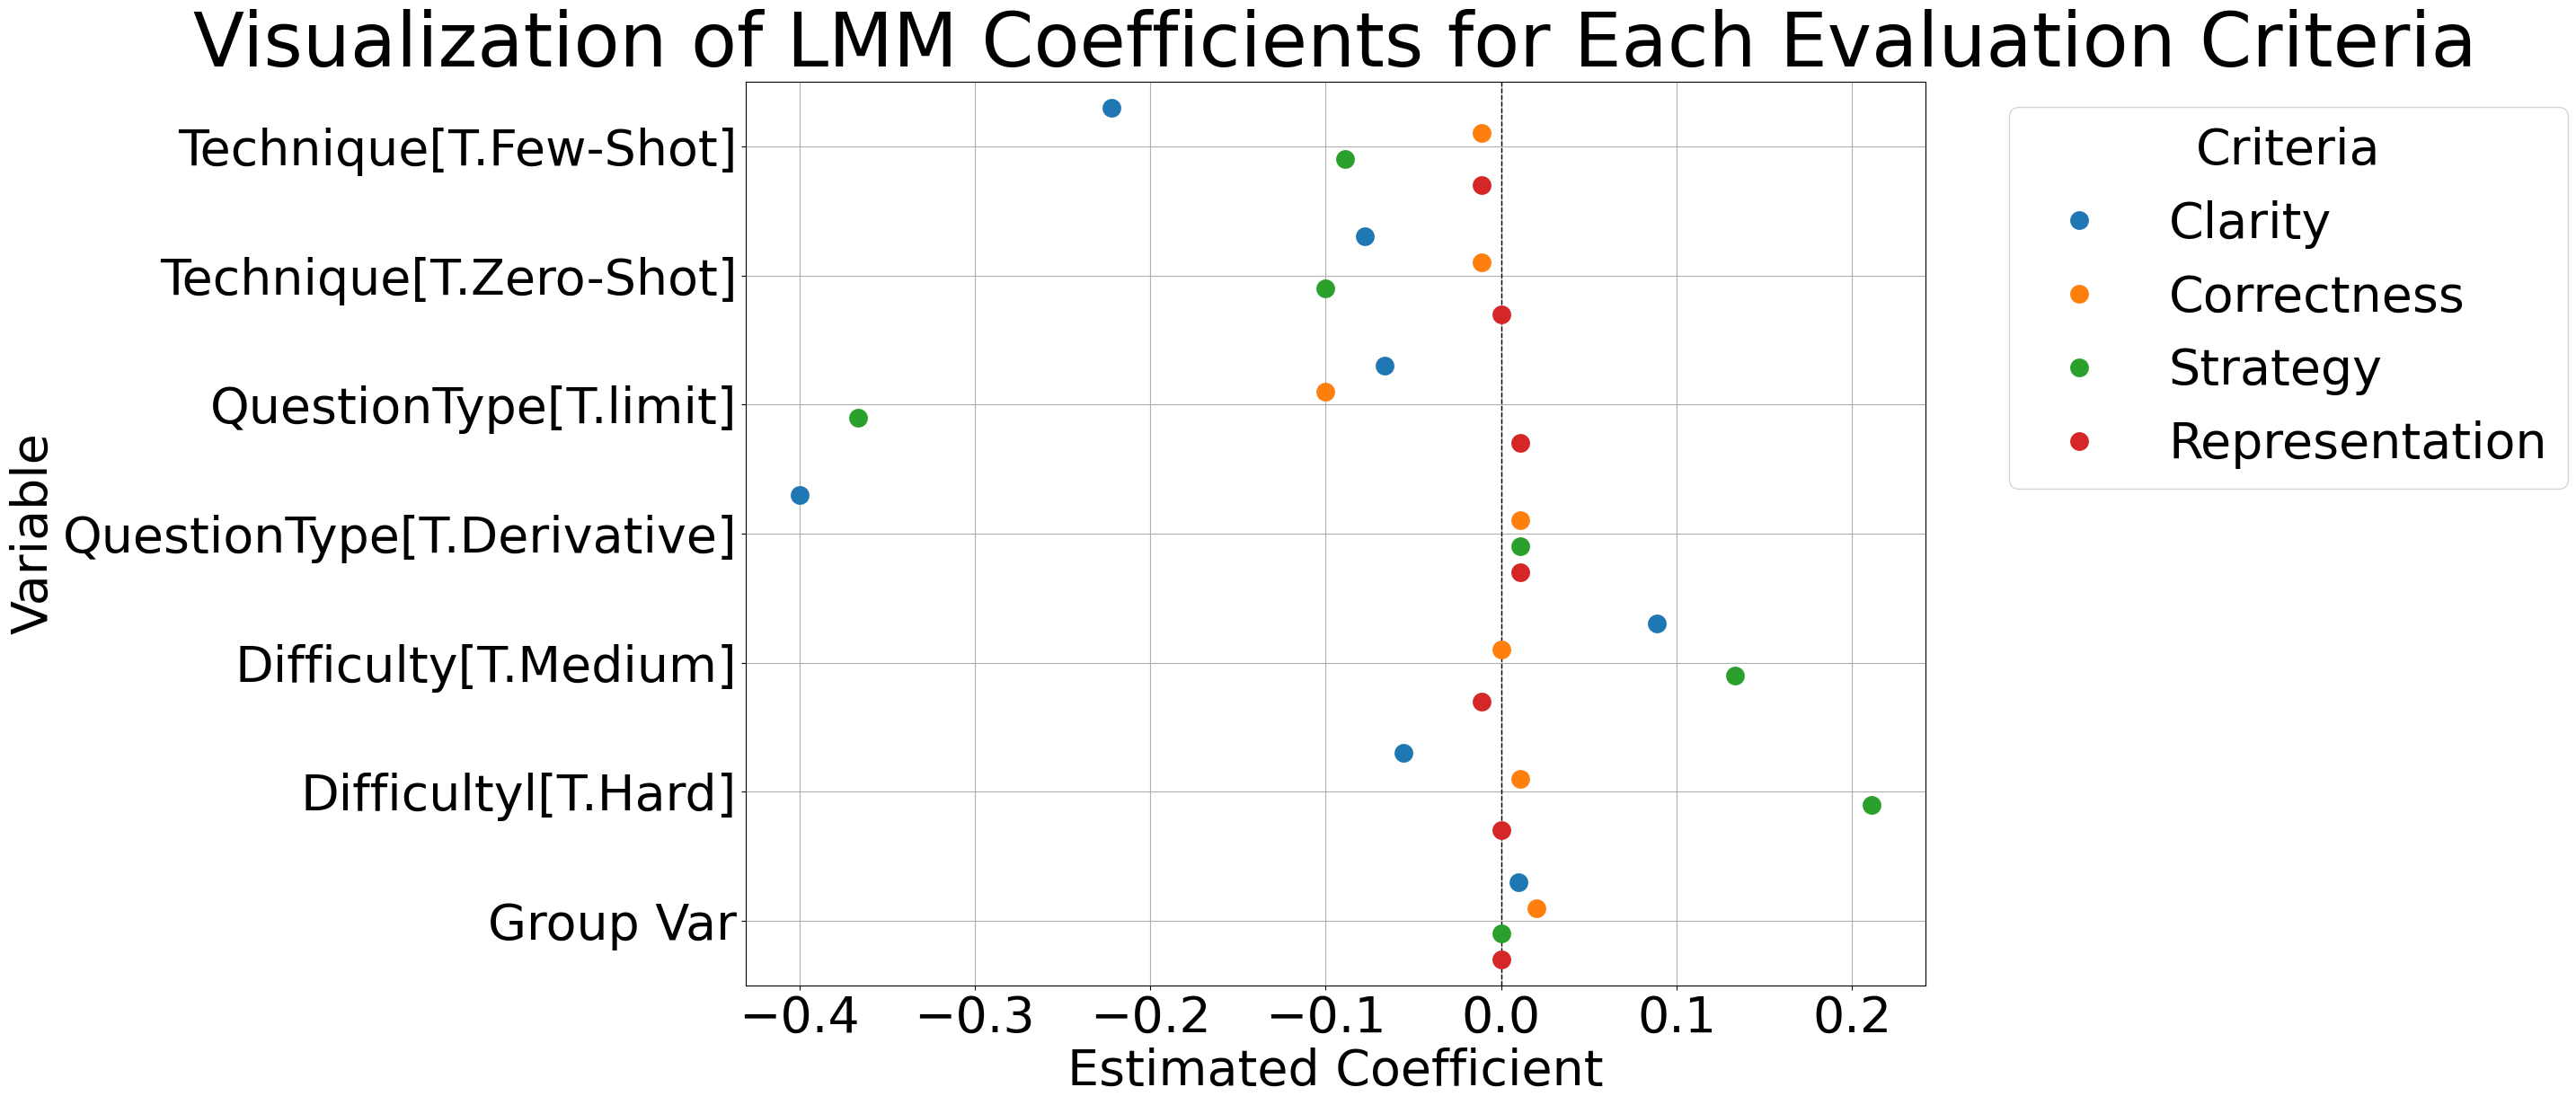

In [ ]:
# Perbaikan visualisasi koefisien LMM tanpa garis CI dengan font lebih besar dan label bahasa Inggris
plt.figure(figsize=(16, 12)) # Increased figure size

# Tambahkan urutan indeks untuk mengatur posisi titik per kategori
coef_df_sorted = coef_df.copy()
coef_df_sorted["idx"] = coef_df_sorted.groupby("Variabel").cumcount()

# Terjemahkan label variabel ke bahasa Inggris
translation_dict = {
    'Teknik[T.Few-Shot]': 'Technique[T.Few-Shot]',
    'Teknik[T.Zero-Shot]': 'Technique[T.Zero-Shot]',
    'JenisSoal[T.limit]': 'QuestionType[T.limit]',
    'JenisSoal[T.turunan]': 'QuestionType[T.Derivative]',
    'Tingkat_kesulitan[T.sedang]': 'Difficulty[T.Medium]',
    'Tingkat_kesulitan[T.sulit]': 'Difficultyl[T.Hard]',
    'Group Var': 'Group Var' # Keep 'Group Var' as is or translate if needed
}
coef_df_sorted['Variabel'] = coef_df_sorted['Variabel'].replace(translation_dict)


# Gunakan seaborn stripplot agar setiap kombinasi Kriteria ditampilkan berdampingan per Variabel
sns.stripplot(data=coef_df_sorted, x="Koefisien", y="Variabel", hue="Kriteria", dodge=True, palette="tab10", jitter=False, size=15) # Increased point size


plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title("Visualization of LMM Coefficients for Each Evaluation Criteria", fontsize=60) # Changed title to English
plt.xlabel("Estimated Coefficient", fontsize=40) # Changed xlabel to English
plt.ylabel("Variable", fontsize=40) # Changed ylabel to English
plt.grid(True)
plt.tight_layout()
plt.legend(title="Criteria", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=40, title_fontsize=40) # Changed legend title to English
plt.tick_params(axis='both', which='major', labelsize=40) # Increased tick label font size
plt.show()